In [11]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, pbfs_search, BFSVisitor, Graph, min_spanning_tree
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.5

pos = graphviz_layout(gnx, root=0)

In [ ]:
from utils import earliest_obs_node
from tqdm import tqdm
from feasibility import is_order_respected, is_feasible
from steiner_tree_mst import steiner_tree_mst


infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True,
                                                                       source_includable=True)
root = earliest_obs_node(obs_nodes, infection_times)

closure_tree = steiner_tree_mst(
    g, root, infection_times, source, obs_nodes,
    strictly_smaller=False,
    debug=False,
    verbose=False,
    return_closure=False
)

In [ ]:
from temporal_bfs import temporal_bfs

tbfs_tree = temporal_bfs(
    g, root, infection_times, source, obs_nodes,
)

In [ ]:
from steiner_tree import get_steiner_tree
st_tree = get_steiner_tree(
            g, obs_nodes,
            debug=False,
            verbose=False,
        )
st_tree_dir = to_directed(g, st_tree, root)

In [8]:
from ic import MAXINT, get_infection_time
def infer_infection_time_from_tree(t, source):
    t = GraphView(t)
    b = t.new_vertex_property('bool')
    b.a = True
    t.set_vertex_filter(b)
    times = get_infection_time(t, source=source)
    return times

In [ ]:
extract_edges(closure_tree)

In [ ]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infer_infection_time_from_tree(closure_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=True,
             ax=ax[0, 1], arrows=True,
             edges=extract_edges(closure_tree))
plot_snapshot(gnx, pos, infer_infection_time_from_tree(tbfs_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0], arrows=True,
              edges=extract_edges(tbfs_tree))
plot_snapshot(gnx, pos, infer_infection_time_from_tree(st_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 1], arrows=True,
              edges=extract_edges(st_tree_dir))

In [ ]:
from feasibility import is_arborescence
is_arborescence(st_tree)

In [ ]:
def to_directed(g, t, root):
    new_t = Graph(directed=True)
    all_edges = set()
    for target in t.vertices():
        path = shortest_path(t, source=root, target=t.vertex(target))[0]
        edges = set(zip(path[:-1], path[1:]))
        all_edges |= edges
    new_t = Graph(directed=True)
    for _ in range(g.num_vertices()):
        new_t.add_vertex()
    for u, v in all_edges:
        new_t.add_edge(int(u), int(v))
    return new_t    

In [ ]:
def get_leaves(t):
    return [v for v in t.vertices() if v.out_degree() == 0 and v.in_degree() > 0]

def get_paths(t, terminals):
    return [list(map(int, shortest_path(t, source=source, target=t.vertex(int(n)))[0]))
            for n in terminals]

In [ ]:
def jaccard_sim(s1, s2):
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [ ]:
from graph_tool.topology import shortest_path
from scipy.stats import kendalltau
leaves = get_leaves(true_tree)
true_tree_paths = get_paths(true_tree, leaves)

def get_rank_corrs(tree, true_tree_paths, debug=False):
    pred_leaves = get_leaves(tree)
    #     print(pred_leaves)
    corrs = []
    if debug:
        print('pred_leaves', pred_leaves)
    for o in pred_leaves:
        path = shortest_path(tree, source=root, target=tree.vertex(o))[0]
        path = list(map(int, path))
        path_nodes = set(path)

        if path_nodes:
            best_true_path = max(true_tree_paths,
                                 key=lambda true_path: jaccard_sim(set(true_path), path_nodes))

            # some similarity        
            if debug:
                print('path', path)
                print('best_true_path', best_true_path)
            common_nodes = path_nodes.intersection(set(best_true_path))
            if debug:
                print('common_nodes', common_nodes)
            n2rank_pred = {n: i for i, n in enumerate(path)}
            n2rank_true = {n: i for i, n in enumerate(best_true_path)}
            if debug:
                print('n2rank_pred', n2rank_pred)
                print('n2rank_true', n2rank_true)
            pred_rank = [n2rank_pred[n] for n in common_nodes]
            true_rank = [n2rank_true[n] for n in common_nodes]

            if debug:
                print('pred_rank', pred_rank)
                print('true_rank', true_rank)                
            corr = kendalltau(pred_rank, true_rank)
            
            if debug:
                print('corr', corr[0])
                print()
            corrs.append(corr[0])
    #             print()
    return corrs

In [ ]:
print(np.mean(get_rank_corrs(true_tree, true_tree_paths, debug=False)))
print(np.mean(get_rank_corrs(closure_tree, true_tree_paths, debug=False)))
print(np.mean(get_rank_corrs(st_tree_dir, true_tree_paths, debug=False)))

In [12]:
import pickle as pkl
p = 'outputs/paper_experiment/grid-64/si/tbfs/qs/0.1/1.pkl'
infection_times, source, obs_nodes, true_edges, pred_edges = pkl.load(open(p, 'rb'))

In [13]:
from utils import edges2graph
true_tree = edges2graph(g, true_edges)
pred_tree = edges2graph(g, pred_edges)
root = next(v for v in pred_tree.vertices() if v.in_degree() == 0 and v.out_degree() > 0)
print(root)

9


In [24]:
print(pred_edges)
print(extract_edges(pred_tree))

[(10, 9), (18, 10), (26, 18), (34, 26), (41, 40), (42, 43), (42, 34), (42, 41), (43, 51), (51, 52)]
[(9, 10), (10, 18), (18, 26), (26, 34), (34, 42), (40, 41), (41, 42), (42, 43), (43, 51), (51, 52)]


In [19]:
from utils import get_leaves, get_paths
from evaluate import get_rank_corrs
leaves = get_leaves(true_tree)
true_tree_paths = get_paths(true_tree, root, leaves)

get_rank_corrs(pred_tree, root, true_tree_paths, debug=True)

pred_leaves [<Vertex object with index '52' at 0x7f70e5742270>]
path [9, 10, 18, 26, 34, 42, 43, 51, 52]
best_true_path [9, 17, 25, 33, 34, 42, 43]
common_nodes {9, 34, 43, 42}
n2rank_pred {43: 6, 34: 4, 42: 5, 52: 8, 51: 7, 9: 0, 10: 1, 18: 2, 26: 3}
n2rank_true {33: 3, 34: 4, 17: 1, 25: 2, 9: 0, 42: 5, 43: 6}
pred_rank [0, 4, 6, 5]
true_rank [0, 4, 6, 5]
corr 1.0



[1.0000000000000002]

<IPython.core.display.Javascript object>


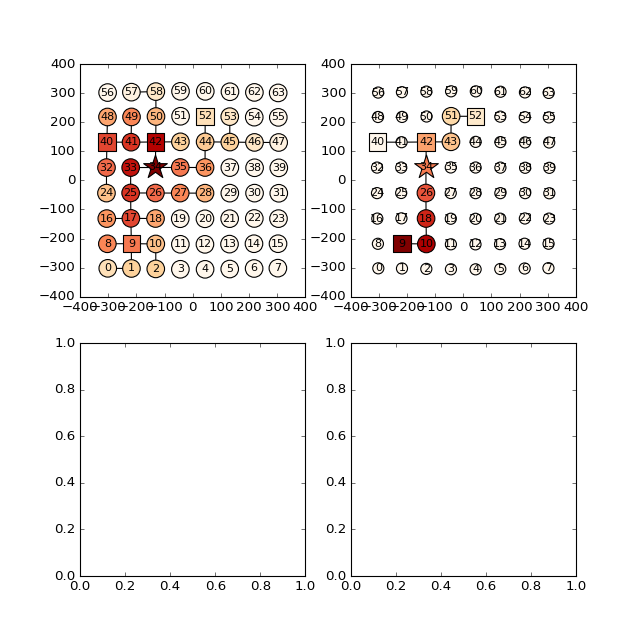

In [20]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infer_infection_time_from_tree(pred_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=True,
             ax=ax[0, 1], arrows=True,
             edges=extract_edges(pred_tree))
